# Modelling the Coronavirus outbreak in the Netherlands

## Background and model dynamics

The main purpose of the notebook is to:

- Understand better the dynamics of the Coronavirus outbreak -> what are key parameters?
- Understand the current development -> is the curve 'flattening'?
- Think about possible mitigation strategies

I will use the SEIR model to model the epidemic. This broadly used model is explained here: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

In short, it assumes that in a population there are four compartments of people during an infection:

- $S$ - Susceptible - not yet sick, but can become sick 
- $E$ - Exposed - people who have the virus, and are in the incubation period. They are not infectious or sick yet
- $I$ - Infected - people who are sick and infectious
- $R$ - Removed - people who either recovered or died from the virus

With $N$ being the total population, the following equation holds at all times: $N$ = $S$ + $E$ + $I$ + $R$



If we simplify by neglecting for the moment birth rates & deaths (other than from Corona), the model is governed by the following equations;


\begin{aligned}{\frac{dS}{dt}}&= -\beta {\frac {I}{N}}S,\\[8pt]{\frac {dE}{dt}}&=\beta {\frac {I}{N}}S- a E,\\[8pt]{\frac {dI}{dt}}&=aE-\gamma I,\\[8pt]{\frac {dR}{dt}}&=\gamma I .\end{aligned}

with key parameters;

\begin{aligned}{a^{-1} = T_{incubation}},\\
\\
{\beta^{-1} = T_{contacts}}, \\
\\
\gamma^{-1} = T_{recovery},\\
\\
R_0 = \frac{\beta}{\gamma}.\end{aligned}


where $T_{contacts}$ is the typical time between contacts, $T_{recovery}$ the typical time to recovery and $T_{incubation}$ the average incubation time.

## Expanding the model

In order to model the current epidemic properly, we have to expand the SEIR model with some buckets & parameters. The flow chart below depicts the dynamics of the model that we are using. This is loosely based on the following model:
https://www.medrxiv.org/content/10.1101/2020.03.18.20038612v1.full.pdf

In [314]:
%%html
<img src = "img/SEIR.png", width = 600, height = 400)>

The above schematic model is characterized by the following containers;

- $S$ - Susceptible - not yet sick, but can become sick 
- $E$ - Exposed - people who have the virus, and are in the incubation period. They are not infectious or sick yet 
- $I$ - Infected - consists of two separate containers; $I$ = $I_{A}$ + $I_{S}$
    - $I_{A}$ Asymptomatic (& mild) cases that will not end up at hospital, but can infect others
    - $I_{S}$ Symptomatic cases that end up at the hospital: there are two containers with $I_{S}$ = $H_{R}$ + $H_{IC}$:
        - $H_{R}$ Regular hospitalizations where people do not need IC 
        - $H_{IC}$ IC hospitalizations
- $R$ - Removed - We have now split this up in two containers, recovered and deaths, where $R$ = $R_{ec}$ + $D$
    - $R_{R}$ People who have recovered from the illness, they can come from Asymptomatic, Hospitalized and IC cases
    - $R_{d}$ People who have died from the illness, they can come from hospitalized and IC cases

Next to this we have the following additional key parameters:
- $\beta_1^{-1}$, $\beta_2^{-1}$ - respectively the time between contacts of 1) asymptomatic (& mild), and 2) (severe) symptomatic cases 
- s - the hospitalization rate, the rate at which people become hospitalized
- $\lambda^{-1}$ - the mean time between development of symptoms & admittance to hospital
- c - the IC rate, rate at which people are admitted to the IC
- d$_{1}$, d$_{2}$ - the mortality rates for respectively people in 1) IC and in 2) hospital care
- $\delta_{1}$, $\delta_{2}$ - the mean times from respectively 1) IC admittance and 2) hospitalization to death
- $\gamma_{1}$, $\gamma_{2}$, $\gamma_{3}$ - the mean times from respectively 1) IC admittance, 2) hospitalization and 3) Asymptomatic cases to recovery

### Equations

The above model is then governed by the following equations:

\begin{aligned}{\frac{dS}{dt}}&= -(\beta_1 I_A + \beta_2 I_S) {\frac {S}{N}},
\\[8pt]{\frac {dE}{dt}}&=(\beta_1 I_A + \beta_2 I_S) {\frac {S}{N}} - a E,
\\[8pt]{\frac {dI_A}{dt}}&=a(1-s)E-\gamma_3 I_A,
\\[8pt]{\frac {dI_S}{dt}}&=asE-\lambda I_S,
\\[8pt]{\frac {dH_R}{dt}}&=\lambda (1-c) I_S - ((1-d_2)\gamma_2 + d_2 \delta_2) H_R ,
\\[8pt]{\frac {dH_{IC}}{dt}}&=\lambda c I_S - ((1-d_1)\gamma_1 + d_1 \delta_1) H_{IC},
\\[8pt]{\frac {dR_R}{dt}}&=(1-d_1)\gamma_1 H_{IC} + (1-d_2)\gamma_2 H_R + \gamma_3 I_A
\\[8pt]{\frac {dR_D}{dt}}&=d_1 \delta_1 H_{IC} + d_2 \delta_2 H_R
\end{aligned}

### Assumptions

We have a number of assumptions in this model:
1. We assume that people admitted to the hospital & IC will immediately end up at those departments, so no movement between departments
2. We have used asymptomatic as a name to depict cases that do not end up at the hospital, this therefore also includes mild symptomatic cases
3. We are assuming that mortality rate in the asymptotic and mild cases is zero
4. Birth rate and deaths (other than corona) have been put to zero

In [239]:
#the code in this notebook is based on the work done in https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# First we will import some packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#We create a function to model the above differential equations, with: 
#y a vector of S, E, I_A, I_S, H_R, H_IC, R_R and R_D
#N the population size, 
#a the average incubation period, 
#beta1 the time between contacts for asymptotic cases, and beta2 for symptomatic cases, 
#c the IC rate for people with severe conditions, 
#d1 mortality rate for IC admitted patients and d2 for hospitalized patients, 
#delta1 the mean time to death from IC admittance and delta 2 from hospitalization
#gamma1 the recovery time from IC admittance, gamma2 from hospitalization, gamma3 from asymptotic cases
def deriv(y, t, N, a, beta1, beta2, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3):
    S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T = y
    dSdt = -(beta1 * I_A + beta2 * I_S) * S / N
    dEdt = (beta1 * I_A + beta2 * I_S) * S / N - a * E
    dI_Adt = a * (1-s) * E - gamma3 * I_A
    dI_Sdt = a * s * E - lam * I_S
    dH_Rdt = lam * (1-c) * I_S - ((1-d2) * gamma2 + d2 * delta2)* H_R
    dH_ICdt = lam * c * I_S - ((1-d1)* gamma1 + d1 * delta1)* H_IC
    dR_Rdt = (1-d1)* gamma1*H_IC + (1-d2) * gamma2 * H_R + gamma3 * I_A
    dR_Ddt = d1 * delta1 * H_IC + d2 * delta2 * H_R
    dTdt = dSdt + dEdt + dI_Adt + dI_Sdt + dH_Rdt + dH_ICdt + dR_Rdt + dR_Ddt
    return dSdt, dEdt, dI_Adt, dI_Sdt, dH_Rdt, dH_ICdt, dR_Rdt, dR_Ddt, dTdt

#A function to simulate an integration over time, with S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0, T0 the starting conditions of the function, 
#t_n the number of steps (days), and N the population size
def simulation(S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0, T0, t_n, N, a, beta1, beta2, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3):
    t = np.linspace(0, t_n-1, t_n)
    y0 = S0, E0, I_A0, I_S0, H_R0, H_IC0, R_R0, R_D0, T0
    ret = odeint(deriv, y0, t, args=(N, a, beta1, beta2, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3))
    S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T = ret.T
    return S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T, N, t

# a function to plot the simulation
def plot(S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,N,t,scale):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/scale, 'orange', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E/scale, 'yellow', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I_A/scale, 'blue', alpha=0.5, lw=2, label='Infected Asymptotic')
    ax.plot(t, I_S/scale, 'pink', alpha=0.5, lw=2, label='Symptomatic')
    ax.plot(t, H_R/scale, 'red', alpha=0.5, lw=2, label='Hospitalized')
    ax.plot(t, H_IC/scale, 'purple', alpha=0.5, lw=2, label='IC')
    ax.plot(t, R_R/scale, 'green', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, R_D/scale, 'black', alpha=0.5, lw=2, label='Deaths')
    ax.plot(t, T/scale, 'black', alpha=0.5, lw=2, label='Total')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,N/1000+50)
    ax.set_ylim(0,500)
    #ax.set_xlim(0,30)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    leg = ax.legend()
    leg.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
    xOffset = 0.5
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
    plt.show()

In [273]:
### Dutch situation
N_NL = 17000000 #pop size
T0 = 17000000
E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0 = 500, 500, 10, 0, 0, 0, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_NL - E0 - I_A0 - I_S0 - R_R0 - R_D0 # Everyone else, S0, is susceptible to infection initially.

R_zero = 2.3

# Estimates for the incubation time, a, the contact rate, beta, and mean recovery time, gamma, (in 1/days).
a, s, lam, c = 1/2, 0.0348, 1/5, 0.3
d1, d2 = 0.35, 0.05
delta1, delta2 = 1/21, 1/14
gamma1, gamma2, gamma3 = 1/21, 1/14, 1/14
beta1, beta2 = 0.25,0.25

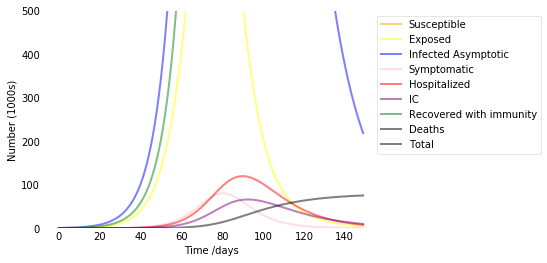

In [274]:
# making a first simulation
S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T, N, t = simulation(S0,E0,I_A0,I_S0,H_R0,H_IC0,R_R0,R_D0,T0, 150,N_NL, a, beta1, beta2, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3)
plot(S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T, N_NL,t,1000)

In [275]:
#Measured infections in the Netherlands
I_measured_NL = np.array([10,20,30,40,80,130,190,270,320,380,500,610,800,960,1140,1410,1710,2051,2460,2994,3631,4204,4749,5560,6412,7431])
H_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,124,142,181,271,350,413,537,700,809,1051,1295,1836,2151])
IC_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,130,175,210,281,354,405,487,550,600,625,620])
D_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,10,12,20,24,43,58,76,106,136,179,213,276,356,434])
IC_capacity_NL = np.ones(I_measured_NL.size)*2000

In [ ]:
#t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
t = np.linspace(1, 27,27)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
#ax.plot(t, I_measured_NL, 'b', alpha=0.5, lw=2, label='Infections measured in NL')
#ax.plot(t, H_measured_NL, 'g', alpha=0.5, lw=2, label='Hospital patients measured in NL')
ax.plot(t, I_measured_NL, 'y', alpha=0.5, lw=2, label='IC patients measured in NL')
#ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
#ax.plot(t, IC_capacity_NL, 'orange', alpha=0.5, lw=2, label='IC Capacity NL')
ax.plot(t, H_IC[14:41], 'black', alpha=0.5, lw=2, label='Model IC capacity needed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,2100)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

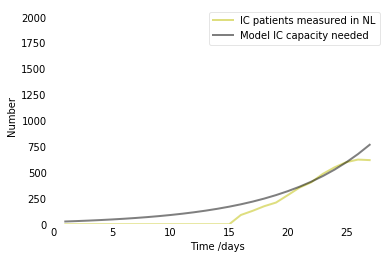

In [276]:
#t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
t = np.linspace(1, 27,27)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
#ax.plot(t, I_measured_NL, 'b', alpha=0.5, lw=2, label='Infections measured in NL')
#ax.plot(t, H_measured_NL, 'g', alpha=0.5, lw=2, label='Hospital patients measured in NL')
ax.plot(t, IC_measured_NL, 'y', alpha=0.5, lw=2, label='IC patients measured in NL')
#ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
#ax.plot(t, IC_capacity_NL, 'orange', alpha=0.5, lw=2, label='IC Capacity NL')
ax.plot(t, H_IC[14:41], 'black', alpha=0.5, lw=2, label='Model IC capacity needed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,2100)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [180]:
#Germany numbers from March 1st 2020 onwards:
I_measured_GER = np.array([130,165,203,262,545,670,800,1040,1224,1565,1966,2745,3675,4599,5813,7272,9367,12327,15320,19848,22364,24873,29056,29056])
H_measured_GER = np.array([])
IC_measured_GER = np.array([])
D_measured_GER = np.array([0,0,0,0,0,0,0,0,2,2,3,6,8,9,13,17,26,28,44,68,84,94,123,0])
IC_capacity_GER = np.ones(I_measured.size)*2000

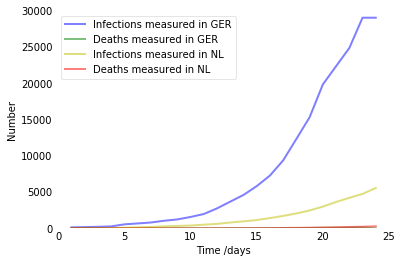

In [181]:
#plotting the real Germany situation
t = np.linspace(1, I_measured_GER.size,I_measured_GER.size)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I_measured_GER, 'b', alpha=0.5, lw=2, label='Infections measured in GER')
ax.plot(t, D_measured_GER, 'g', alpha=0.5, lw=2, label='Deaths measured in GER')
ax.plot(t, I_measured_NL, 'y', alpha=0.5, lw=2, label='Infections measured in NL')
ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,30000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [281]:
# Germany situation
N_Ger = 87790000 #pop size
E0, I0, R0 = 4000, 2000, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_Ger - E0 - I0 - R0 # Everyone else, S0, is susceptible to infection initially.

R_zero = 2.4

# Estimates for the incubation time, a, the contact rate, beta, and mean recovery time, gamma, (in 1/days).
a, gamma, beta = 1./2, 1./14, gamma * R_zero
t = 24 # the number of time steps



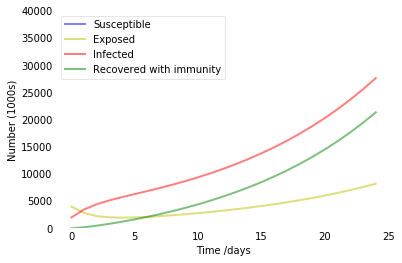

In [282]:
#Germany simulation
S,E,I,R,N,t = simulation(S0, E0, I0, R0, 25, N_Ger, a, beta, gamma)
plot(S,E,I,R,N,t,1)